In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle

## 1) Importing Data 

In [3]:
sp500=yf.download('^NSEI',start="2018-01-01", end="2022-12-31",interval='1d')

[*********************100%***********************]  1 of 1 completed


In [4]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,10477.549805,10495.200195,10404.650391,10442.200195,10442.200195,153400
2018-01-03,10482.650391,10503.599609,10429.549805,10443.200195,10443.200195,167300
2018-01-04,10469.400391,10513.000000,10441.450195,10504.799805,10504.799805,174900
2018-01-05,10534.250000,10566.099609,10520.099609,10558.849609,10558.849609,180900
2018-01-08,10591.700195,10631.200195,10588.549805,10623.599609,10623.599609,169000


<AxesSubplot:xlabel='Date'>

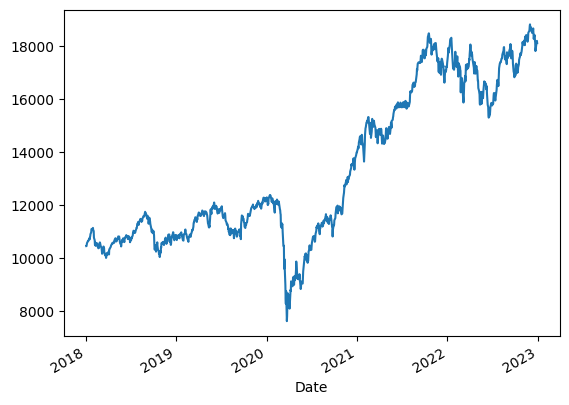

In [5]:
sp500['Adj Close'].plot()

In [6]:
# sp500['Adj Close'].ewm(span=100).mean().plot()

In [7]:
# sp500['Adj Close']=sp500['Adj Close'].ewm(span=80).mean()

<AxesSubplot:xlabel='Date'>

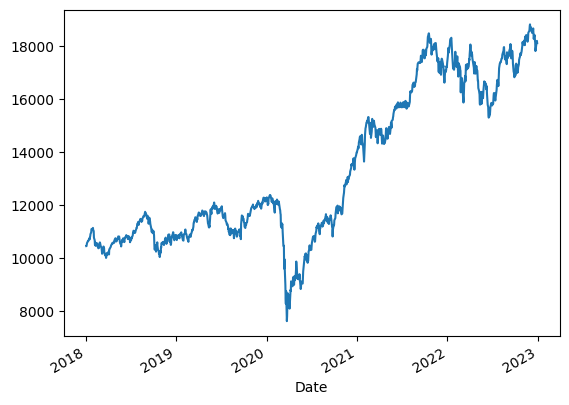

In [8]:
sp500['Adj Close'].plot()

The cyclical component represents phenomena that happen across seasonal periods. Cyclical patterns do not have a fixed period like seasonal patterns do. An example of a cyclical pattern is the cycles of boom and bust that stock markets experience in response to world events. <br>
This data seems to have cyclical component with no consistent cyclicity. So instead of decomposing it into trend, seasonality, noise, we would just keep it as it is.

In [9]:
sp500['Adj Close'].shape

(1232,)

Figure(640x480)


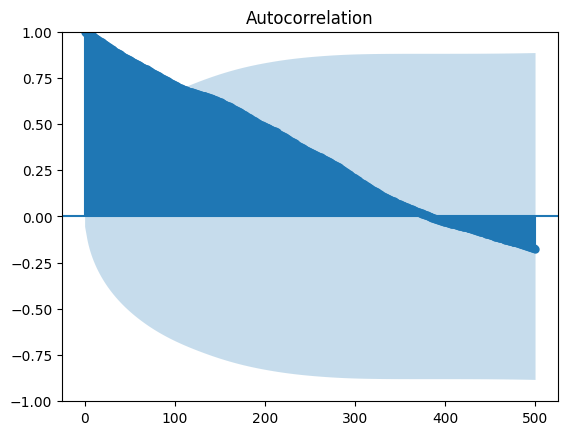

In [10]:
print(plot_acf(sp500['Adj Close'],lags=500))

Also autocorrelation graph shows no seasonal pattern.

## 2) Decomposition of Data 

In [11]:
sp500_decomposition = seasonal_decompose(x=sp500['Adj Close'], model='additive', period=45)

### 2.1) Trend 

<AxesSubplot:xlabel='Date'>

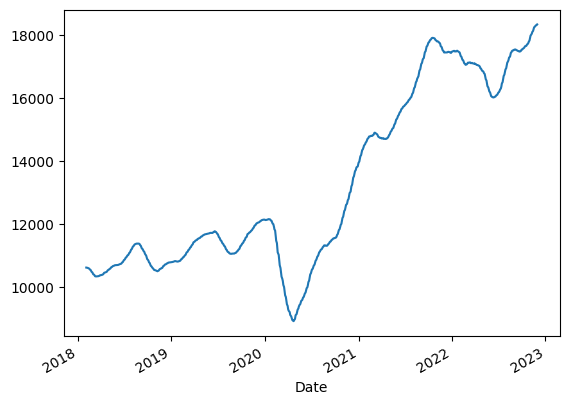

In [12]:
sp500_decomposition.trend.plot()

### 2.2) Seasonal 

<AxesSubplot:xlabel='Date'>

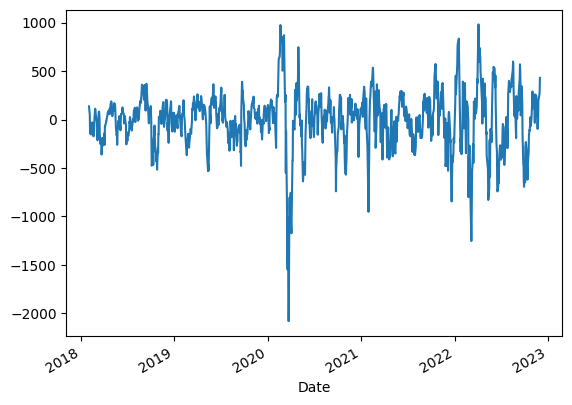

In [13]:
(sp500_decomposition.seasonal+sp500_decomposition.resid).plot()

<AxesSubplot:xlabel='Date'>

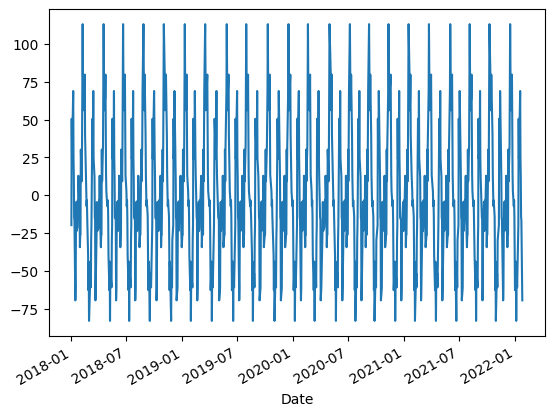

In [14]:
sp500_decomposition.seasonal[:1000].plot()

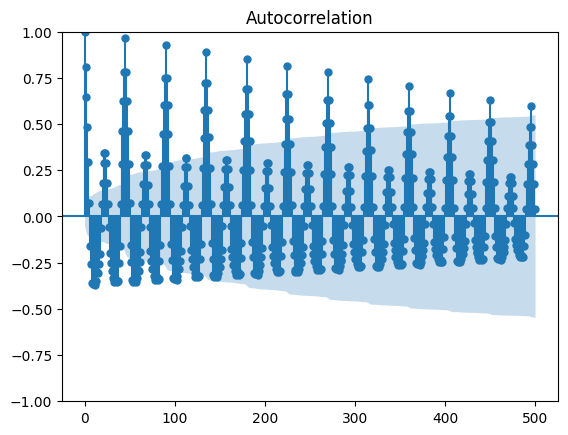

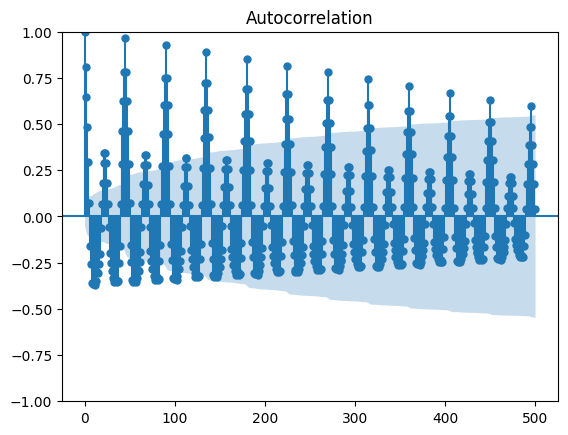

In [15]:
plot_acf(sp500_decomposition.seasonal,lags=500)

### 2.3) Residual 

<AxesSubplot:xlabel='Date'>

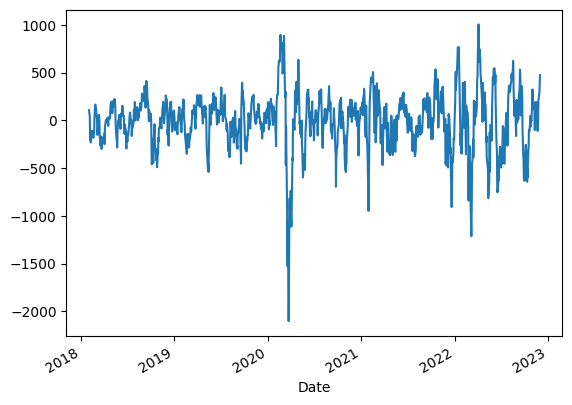

In [16]:
sp500_decomposition.resid.dropna().plot()

## 3) Stationarity Test

<AxesSubplot:xlabel='Date'>

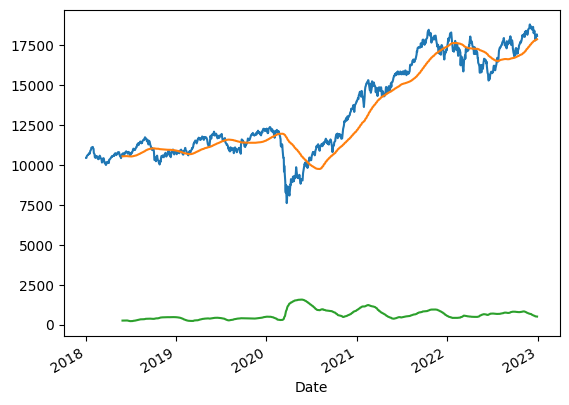

In [17]:
sp500['Adj Close'].plot()
sp500['Adj Close'].rolling(100).mean().plot()
sp500['Adj Close'].rolling(100).std().plot()

### 3.1) Constant Mean Test

In [18]:
# difference between max and min mean
( sp500['Adj Close'].rolling(500).mean().max() - sp500['Adj Close'].rolling(500).mean().min() ) * 100 / sp500['Adj Close'].rolling(500).mean().max()
# The mean appears to be constant considering the value of mean, since the difference between minimum and max is about 17% from it's max value

33.61897850068725

In [19]:
# chunks = np.split(monthly_temp.temp, indices_or_sections=12)

### 3.2) Constant Std Test

In [20]:
# difference between max and min mean
( sp500['Adj Close'].rolling(500).std().max() - sp500['Adj Close'].rolling(500).std().min() ) * 100 / sp500['Adj Close'].rolling(500).std().max()
# the standard deviation is not constant

80.73419731531416

### 3.3) Dickey Fuller Test 

In [21]:
adf_sp500, pvalue_sp500, usedlag_, nobs_, critical_values_sp500, icbest_ = adfuller(sp500['Adj Close'])
pvalue_sp500

0.8894715307286246

The pvalue of dickey fuller should be below 0.05. <br>
The next dickey fuller test would be conducted on a data after removing autocorrelation with differencing. 

In [22]:
sp500_diff=sp500['Adj Close'].diff(periods=1)[~np.isnan(sp500['Adj Close'].diff(periods=1))]
adf_sp500_diff, pvalue_sp500_diff, usedlag_diff, nobs_diff, critical_values_sp500, icbest_diff = adfuller(sp500_diff)
pvalue_sp500_diff

6.379445571986314e-23

The value is lower than 0.05 so, the stationary test is passed.

<AxesSubplot:xlabel='Date'>

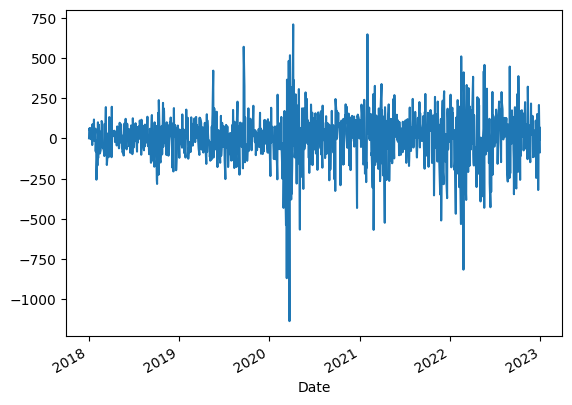

In [23]:
sp500_diff.plot()

### 3.4) Autocorrelation Tests 

Figure(640x480)
Figure(640x480)


C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


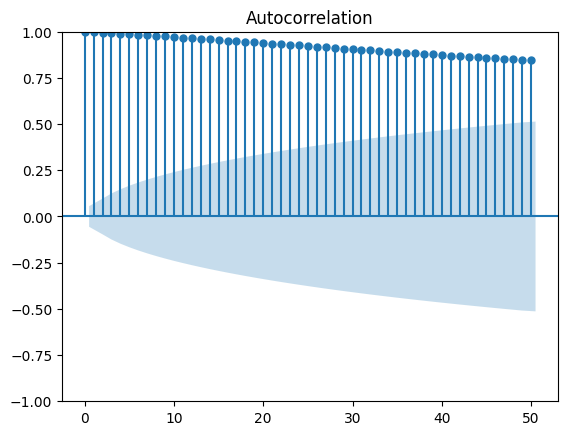

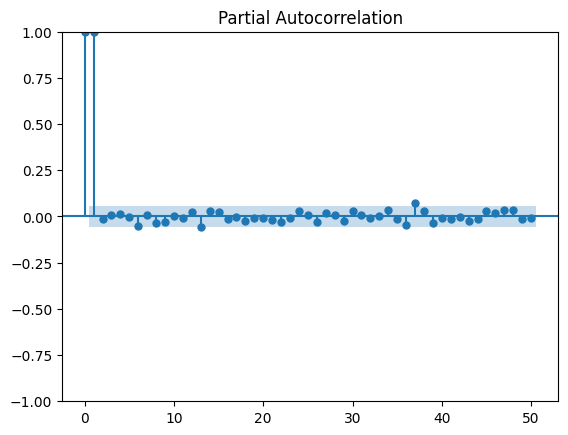

In [24]:
print(plot_acf(sp500['Adj Close'],lags=50))
print(plot_pacf(sp500['Adj Close'],lags=50))

In [25]:
# difference data

Figure(640x480)
Figure(640x480)


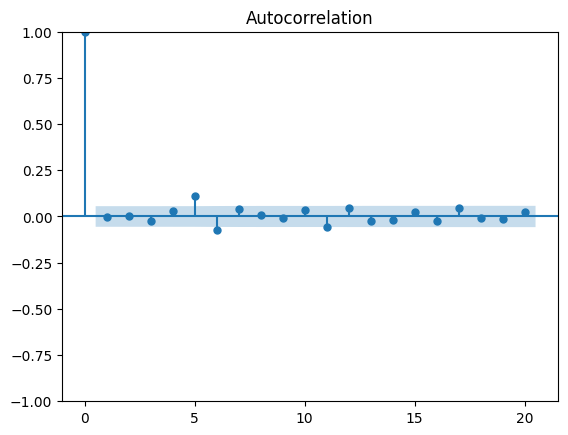

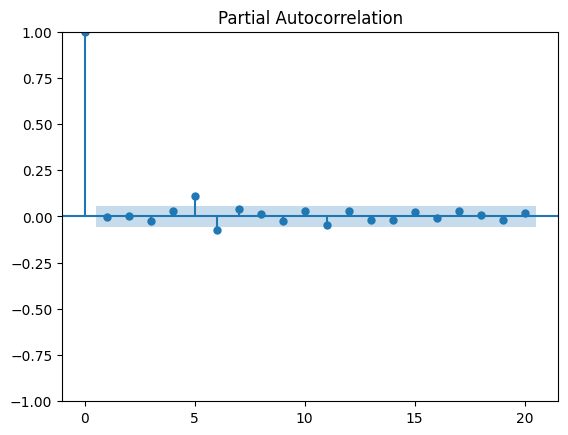

In [26]:
print(plot_acf(sp500_diff,lags=20))
print(plot_pacf(sp500_diff,lags=20))

## 4) Model

In [27]:
'''sar = sm.tsa.statespace.SARIMAX(sp500['Adj Close'], 
                                order=(1,1,1), 
                                seasonal_order=(0,1,1,45), 
                                trend='c').fit()
sar.summary()

# sarima model without seasonality is arima model '''

"sar = sm.tsa.statespace.SARIMAX(sp500['Adj Close'], \n                                order=(1,1,1), \n                                seasonal_order=(0,1,1,45), \n                                trend='c').fit()\nsar.summary()\n\n# sarima model without seasonality is arima model "

In [28]:
#with open('nifty_18_22.pkl', 'wb') as f:
#    pickle.dump(sar, f) 

In [29]:
with open('nifty_18_22.pkl', 'rb') as f:
    sar = pickle.load(f) 

<AxesSubplot:xlabel='Date'>

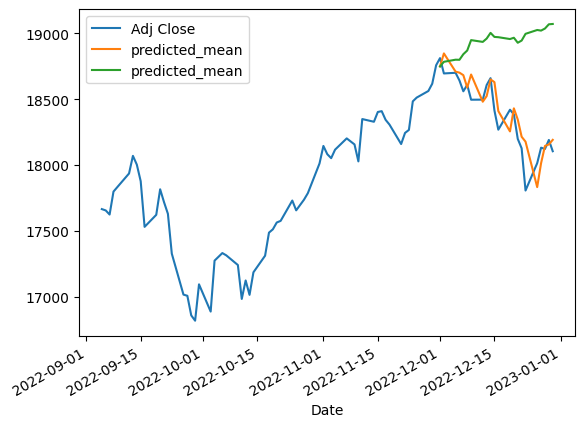

In [34]:
pd.plotting.register_matplotlib_converters()
#use model.predict() start and end in relation to series
 

sp500['Adj Close'][1150:].plot(legend=True)
sar.predict(start=1210).plot(legend=True)
sar.predict(start=1210,dynamic=True).plot(legend=True)
# sar.forecast(steps=100).plot()
# sp500[730:][['Adj Close', 'Adj Close Forecast']].plot();

In [237]:
sp500_fore=yf.download('^NSEI',start="2023-01-01", end="2023-01-30",interval='1d')

[*********************100%***********************]  1 of 1 completed


In [238]:
sp500_fore.shape

(19, 6)

<AxesSubplot:xlabel='Date'>

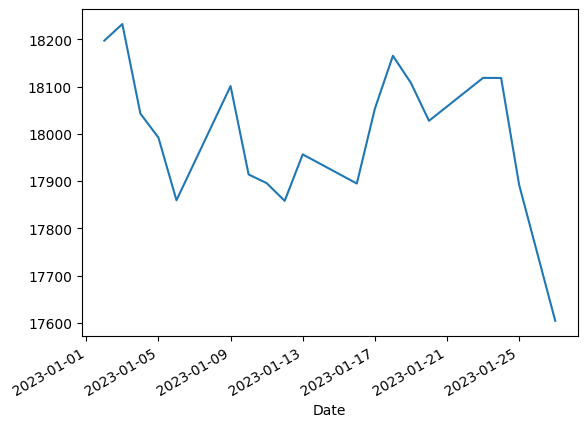

In [239]:
sp500_fore['Adj Close'].plot()

In [240]:
sp500_for=sar.forecast(steps=sp500_fore.shape[0])
sp500_for.index=sp500_fore.index
sp500_for

C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Date
2023-01-02    18140.415629
2023-01-03    18128.705410
2023-01-04    18116.278390
2023-01-05    18134.122880
2023-01-06    18145.274477
2023-01-09    18196.395957
2023-01-10    18186.735724
2023-01-11    18220.866550
2023-01-12    18268.026914
2023-01-13    18322.397596
2023-01-16    18300.154028
2023-01-17    18286.982878
2023-01-18    18305.470034
2023-01-19    18331.522521
2023-01-20    18302.141817
2023-01-23    18286.075431
2023-01-24    18285.626970
2023-01-25    18285.781000
2023-01-27    18299.782536
Name: predicted_mean, dtype: float64

<AxesSubplot:xlabel='Date'>

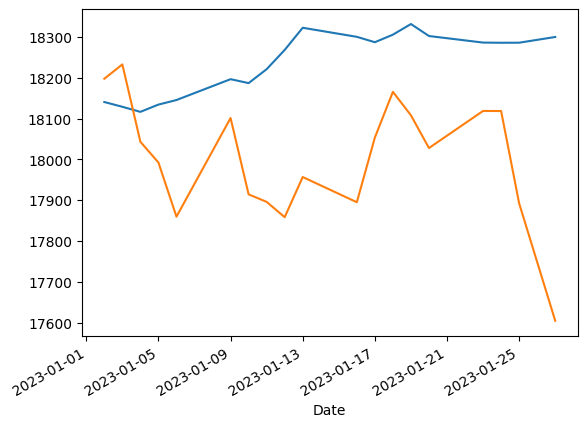

In [241]:
sp500_for.plot()
sp500_fore['Adj Close'].plot()